## Data Science 100: Project Proposal
# Title: Comparison of Predictor Variables in Determining the Prescence of Heart Disease

#### Jamie Robson (student #: 73480238)

#### Introduction
Heart Disease affects nearly 2.6 million people in Canada and is one of the leading cause of death nationally. Heart Disease is an umbrella term for conditions that affect the heart, which is responsible for pumping blood around the body to various systems. It can be caused my high blood pressure, or hypertension, which decreases the amount of blood being pumped and puts strain on the heart (Cleaveland Clinic). Another cause of Heart Disease is high colesterol (Atherosclerosis) which causes a buildup of plaque on the heart ateries and can decrease the amount of blood being pumped by the heart (Mayo Clinic). Heart Disease can cause Tachycardia, an elevated heart rate, which can also decrease the amount of blood being circulated by the heart. While this metric is not always linked to heart disease, people with heart disease tend to have higher heart rates.

Knowing this about heart disease I can ask the question: Along with the maximum heart rate reached for a patient, is resting blood pressure or colesterol levels more accurate in predicting the presence of heart disease?

To evaluate this question I use the Cleaveland Heart Disease Database from the UC Irvine Machine Learning Repository. It contains 14 variables of patient information which includes sex, age and other relevant medical statistics. This dataset indentifies Heart Diseases on a scale from 0-4, however for this study we look at only detecting whether the patient is Heart Disease-less (0) or has Heart Disease (1-4).


In [1]:
#import libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#import dataset from github repository
set.seed(3784)
url <- "https://raw.githubusercontent.com/jrobs12/dsci_project/main/data/heart_disease/processed.cleveland.data"
col_names <- c("age", "sex", "cp", "rest_bp", "col", "fbs", "rest_ecg", "thalach", "ex_ang", 
               "oldpeak", "slope", "ca", "thal", "num")
heart_disease_data <- read_csv(url, col_names = col_names) |>
    #make factor columns factors
    mutate(num = as_factor(num), sex = as_factor(sex), cp = as_factor(cp), 
               slope = as_factor(slope), fbs = as_factor(fbs), ex_ang = as_factor(ex_ang))
#I just want to test for the presence of heart disease so I'm going to modify the num category to be either
#1 or 0
heart_disease_data["num"][heart_disease_data["num"] == "2"] <- "1"
heart_disease_data["num"][heart_disease_data["num"] == "3"] <- "1"
heart_disease_data["num"][heart_disease_data["num"] == "4"] <- "1"

#make training and testing data
heart_cut <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_training <- training(heart_cut)
#this isn't needed for the proposal but I might as well do it now
heart_testing <- testing(heart_cut)

heart_training

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, rest_bp, col, fbs, rest_ecg, thalach, ex_ang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,rest_bp,col,fbs,rest_ecg,thalach,ex_ang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<chr>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [3]:
#summarize some of the columns
heart_table <- heart_training |> group_by(num) |> 
    select(rest_bp, col, thalach, num) |>
    summarize(mean_col = mean(col), sd_col = sd(col), length_col = length(col), 
              mean_bp = mean(rest_bp), sd_bp = sd(rest_bp), length_bp = length(rest_bp),
            mean_thalach = mean(thalach), sd_thalach = sd(thalach), length_thalach = length(thalach))

#center and scale the data to see if there are any patterns
heart_scaled <- heart_training |> select(col, rest_bp, num, thalach) |> mutate(col_scaled = scale(col, center = TRUE), 
                                                                      bp_scaled = scale(rest_bp, center = TRUE), 
                                                                           thalach_scaled = scale(thalach, center = TRUE))
print("Table of Summarising Values for the Training Dataset")
heart_table

[1] "Table of Summarising Values for the Training Dataset"


num,mean_col,sd_col,length_col,mean_bp,sd_bp,length_bp,mean_thalach,sd_thalach,length_thalach
<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
0,245.3089,51.36579,123,129.4634,15.35391,123,159.6748,18.34170,123
1,253.5000,48.51724,104,133.8365,19.36472,104,139.2308,23.06606,104


[1] "Figure 3: Distributions of Variables"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


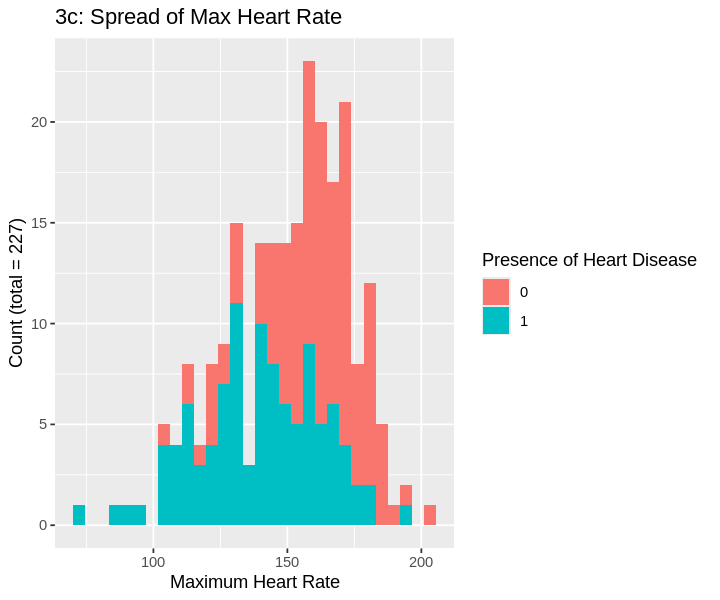

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


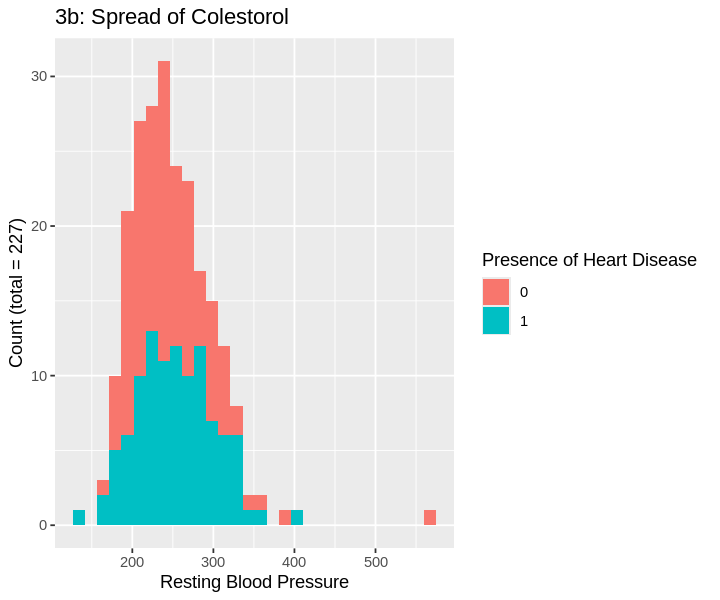

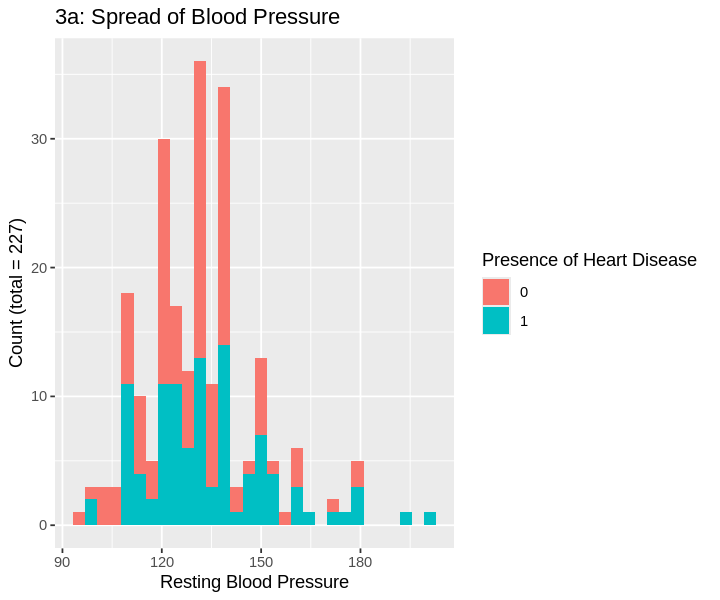

In [25]:
#make histograms of variables
bp_hist <- heart_scaled |> ggplot(aes(x = rest_bp, 
                                              fill = num)) + 
            geom_histogram() + 
            labs(x = "Resting Blood Pressure", title = "3a: Spread of Blood Pressure", 
            fill = "Presence of Heart Disease", y = "Count (total = 227)")

col_hist <- heart_scaled |> ggplot(aes(x = col, 
                                              fill = num)) + 
            geom_histogram() + 
            labs(x = "Resting Blood Pressure", title = "3b: Spread of Colestorol", 
            fill = "Presence of Heart Disease", y = "Count (total = 227)")

age_hist <- heart_scaled |> ggplot(aes(x = thalach, 
                                              fill = num)) + 
            geom_histogram() + 
            labs(x = "Maximum Heart Rate", title = "3c: Spread of Max Heart Rate", 
            fill = "Presence of Heart Disease", y = "Count (total = 227)")
print("Figure 3: Distributions of Variables")
age_hist
col_hist
bp_hist

#### Methods
This study will use a K-nearest neighbour algorithm to predict if an individual in our test dataset has Heart Disease using either maximum heart rate and colesterol or max heart rate and resting blood pressure. This will be done with 2 models using the k nearest neighbour algorithm from kknn and tidymodels with K = 5. The data has been changed so that if the patient has Heart Disease (regarless of stage or class) it's value in "num" is 1 and if not then the value is 0.

The models will be evaluated based on the accuracy of the predictions. To do this I will make a bar chart of the predictions and color the bars based on accuracy. There will be 2 plots: "Accuracy of the blood pressure trial" and "accuracy of the colesterol trial".

#### Expected Outcomes

I anticipate that there will not be a large difference between the predictions since the spreads of both variables are both quite large and there is no clear difference between the individuals who have heart disease and those who do not. 

This study may inspire future research into potentially using both resting blood pressure AND colesterol to try to predict the presence of heart disease in a patient.

## Blood Pressure Analysis

In [6]:
## finding the optimal K for analysis
set.seed(4000)
options(repr.plot.height = 5, repr.plot.width = 6)
vfold <- vfold_cv(heart_training, v = 5, strata = num)

tuning_spec <- nearest_neighbor(weight_func = "rectangular", n = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

possible_ks <- tibble(neighbors = c(2:100))

bp_recipe <- recipe(num ~ rest_bp + thalach, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tuning_workflow_bp <- workflow() |>
    add_recipe(bp_recipe) |>
    add_model(tuning_spec) |>
    tune_grid(resamples = vfold, grid = possible_ks) |>
    collect_metrics()

metrics_bp <- tuning_workflow_bp |>
    filter(.metric == "accuracy") |>
    select(mean, neighbors)

cross_val_plot_bp <-  metrics_bp |>
            ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() +
            labs(x = "Number of Neighbors", y = "Accuracy", title = "figure 2a: Accuracy of Different Ks for BP Analysis")
k_bp <- metrics_bp |>
    arrange(desc(mean)) |>
    slice(1)|>
    pull(neighbors)

→ A | warning: No observations were detected in `truth` for level(s): '2', '3', '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x3

There were issues with some computations   A: x4

There were issues with some computations   A: x5

There were issues with some computations   A: x5





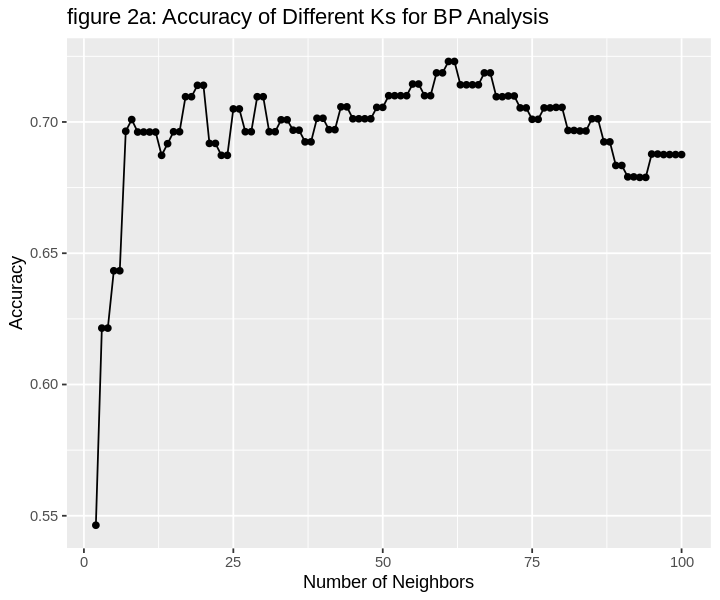

In [7]:
cross_val_plot_bp

In [8]:
## make a new model and workflow with the best K
bp_spec <- nearest_neighbor(weight_func = "rectangular", n = k_bp) |>
    set_engine("kknn") |>
    set_mode("classification")
bp_workflow <- workflow() |>
    add_recipe(bp_recipe) |>
    add_model(bp_spec) |>
    fit(data = heart_training)

In [9]:
## predict the testing data
set.seed(2000) 
bp_preds <- predict(bp_workflow, heart_testing) |>
    bind_cols(heart_testing)
bp_prediction_metrics <- bp_preds |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)
bp_conf_mat <- bp_preds |>
    conf_mat(truth = num, estimate = .pred_class)

In [10]:
bp_prediction_metrics

[1] 0.6710526

## Colesterol Analysis

In [11]:
## finding the optimal K for analysis
set.seed(1234)
options(repr.plot.height = 5, repr.plot.width = 6)

col_recipe <- recipe(num ~ col + thalach, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tuning_workflow_col <- workflow() |>
    add_recipe(col_recipe) |>
    add_model(tuning_spec) |>
    tune_grid(resamples = vfold, grid = possible_ks) |>
    collect_metrics()

metrics_col <- tuning_workflow_col |>
    filter(.metric == "accuracy") |>
    select(mean, neighbors)

cross_val_plot_col <-  metrics_col |>
            ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() +
            labs(x = "Number of Neighbors", y = "Accuracy", title = "figure 2b: Accuracy of Different Ks for Colesterol Analysis")
k_col <- metrics_col |>
    arrange(desc(mean)) |>
    slice(1)|>
    pull(neighbors)

→ A | warning: No observations were detected in `truth` for level(s): '2', '3', '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x3

There were issues with some computations   A: x4

There were issues with some computations   A: x5

There were issues with some computations   A: x5





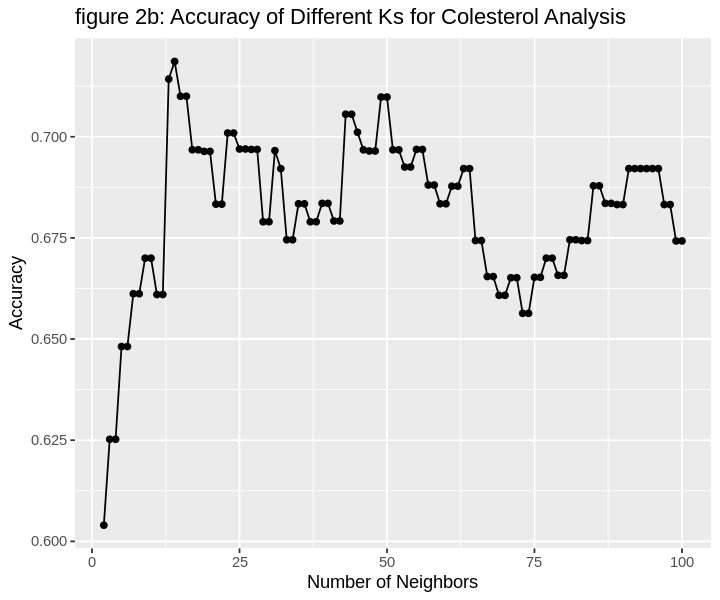

In [12]:
cross_val_plot_col

In [13]:
col_spec <- nearest_neighbor(weight_func = "rectangular", n = k_col) |>
    set_engine("kknn") |>
    set_mode("classification")
col_workflow <- workflow() |>
    add_recipe(col_recipe) |>
    add_model(col_spec) |>
    fit(data = heart_training)

In [14]:
set.seed(3566) 
col_preds <- predict(col_workflow, heart_testing) |>
    bind_cols(heart_testing)
col_prediction_metrics <- col_preds |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)
col_conf_mat <- col_preds |>
    conf_mat(truth = num, estimate = .pred_class)

In [37]:
#make results
results <- tibble(Colesterol = col_prediction_metrics, Blood_Pressure = bp_prediction_metrics) |>
    pivot_wider(names_from = "Factor", values_from = "Accuracy")
results
# results_plot <- results |>
#     ggplot(aes(x = c(col_accuracy, bp_accuracy)) + geom_bar(stat = "identity")

ERROR: [1m[33mError[39m in `pivot_wider()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `Factor` doesn't exist.


In [27]:
results

col_accuracy,bp_accuracy
<dbl>,<dbl>
0.6578947,0.6710526
